# Train Simple Sound Classifers

![Imgur](https://i.imgur.com/UoooCnx.png)

Welcome to an interactive notebook on sound classification. 

To follow along this demo, headphones are recommended to hear sound examples. (Don't forget to turn down the volume first as you can always turn it back up.)

# Outline

### I. Hear the training data

Two small sound datasets can be found in this Jupyter Lab. 

### II. Quick overview: MFCC vs FBANK features

I offer just a *bit* of background to provide some basic context for when you might extract mfcc or fbank features from acoustic data. 

### III. Build sound / noise classifier

I show how one can build a sound classifier, using the sound dataset and extracting mfcc features.

### IV. Build your own...

Suggestions for what you can do, for example, build a speech recognition model using the reduced speech commands dataset provided.

## Important Note: 

### **If you would like to use your own sound files in this notebook, you may need to prepare them for this online environment** (here is my <a href="https://github.com/a-n-rose/python-sound-prep#prepare-audio-for-jupyter-lab">repo</a> that can help). 

### Only .wav files with bitdepth of 16 or 32 are acceptable.

# Let's get started!

In [1]:
# adjust path so we can import the package from the parent directory
import os, sys
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
packagedir = os.path.dirname(currentdir)
sys.path.insert(0, packagedir)

# install what is required to use tools:
# !pip install -r ../requirements.txt

# what is necessary to play audio files in this notebook:
import IPython.display as ipd
from scipy.io.wavfile import read

# what is neceesary for visualizing MFCC and FBANK features
from python_speech_features import mfcc, logfbank
import matplotlib.pyplot as plt
import numpy as np

### Set directories for training data

In [2]:
path2audiodata = '../audiodata/minidatasets/'
path2_speechcommands_data = '{}speech_commands/'.format(path2audiodata)
path2_backgroundnoise_data = '{}background_noise/'.format(path2audiodata)

# Hear the training data
Two small sound datasets can be found in this Jupyter Lab. 

* background noise
* speech commands

One dataset contains recordings of background noise. Some of these were collected from <a href="https://freesound.org/">freesound.org</a> and others I recorded with my own smartphone. 

The other dataset is a reduced collection from Google's <a href="https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html">speech commands</a> dataset from 2017.

I offer these two datasets so you can explore how different acoustic data (noise vs. speech) as well features extracted from these data (<a href="https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html">MFCC vs FBANK</a>) influence the training of acoustic models.


#### Background Noise: train

In [3]:
train = '{}train/331907.wav'.format(
    path2_backgroundnoise_data)
sr, samps = read(train)
ipd.Audio(samps,rate=sr)

#### Background Noise: street

In [4]:
street = '{}street/2019-08-19 10.07.443.wav'.format(
    path2_backgroundnoise_data)
sr, samps = read(street)
ipd.Audio(samps,rate=sr)

#### Background Noise: cafe

In [5]:
cafe = '{}cafe/cafe18.wav'.format(
    path2_backgroundnoise_data)
sr, samps = read(cafe)
ipd.Audio(samps,rate=sr)

#### Speech Commands: nine 

In [6]:
nine = '{}nine/ffd2ba2f_nohash_3.wav'.format(
    path2_speechcommands_data)
sr, samps = read(nine)
ipd.Audio(samps,rate=sr)

#### Speech Commands: right 

In [7]:
right = '{}right/fafe8101_nohash_0.wav'.format(
    path2_speechcommands_data)
sr, samps = read(right)
ipd.Audio(samps,rate=sr)

#### Speech Commands: zero

In [8]:
zero = '{}zero/efbc3952_nohash_0.wav'.format(
    path2_speechcommands_data)
sr, samps = read(zero)
ipd.Audio(samps,rate=sr)

# Quick Overview: MFCC vs FBANK features

MFCC: Mel Frequency Cepstral Coefficients

FBANK: Log-Mel Filterbank Energies

All you really need to know is that both MFCC and FBANK features are derived from a more complex set of features, termed the Short-Time Fourier Transform (<a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform">STFT</a>). Note: the picture at the top of this page (pictured below) is a 3D representation of what STFT features convey: the frequencies and their energy levels in a sound recording.

![Imgur](https://i.imgur.com/nVGjKeU.png)

Here's more on <a href>spectrograms</a>. 

STFT features contain detailed information about the frequencies in an acoustic signal over time. Great acoustic models can be trained on these features. However, to reduce computational complexity, additional calculations can be applied to reduce the number of features. 

FBANK features are basically STFT features reduced to the frequencies most relevant for human hearing. 

MFCC features are FBANK features further reduced in complexity, where any somewhat repetitive features or collinear features are removed. 

I think <a href="http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/">this post</a> does a good job walking through the steps. In reference to the 6 steps they list in that post: 

* Steps 1 - 2: STFT
* Steps 3 - 4: FBANK
* Steps 5 (optional 6): MFCC

## Visualizing MFCCs and FBANK energies

Below I've put together a function that allows one to explore how the feature extraction process is influenced by the various parameters:

`soundfile` wavfile to be loaded (must be compatible with scipy.io.wavfile)

`features` either 'mfcc' or 'fbank'

`win_size_ms` time in milliseconds, or window size in milliseconds, to apply the FFT

`win_shift_ms` time in milliseconds each window should overlap

`num_filters` number of mel-filters to apply: default is 40 but try out more and fewer

`num_mfcc` (only considered if extracting 'mfcc' features) number of mel frequency cepstral coefficients to apply. For speech, 13-40 is typical. For scene analysis, 40 is typical.

Feel free to try different wavfiles, mess with the window sizes, etc. Note: if you are confused by the labels of the graphs, I apologize. I am still working on scaling the frequencies and time to the features, something the librosa library did for me... I cannot import librosa in JupyterLab and now have to do it myself. Which is good, I guess.


In [9]:
def visualize_feats(soundfile, features='fbank', win_size_ms = 20, \
                    win_shift_ms = 10, num_filters=40,num_mfcc=40):
    sr, data = read(soundfile)
    win_samples = int(win_size_ms * sr // 1000)
    if 'fbank' in features:
        feats = logfbank(data,
                         samplerate=sr,
                         winlen=win_size_ms * 0.001,
                         winstep=win_shift_ms * 0.001,
                         nfilt=num_filters,
                         nfft=win_samples)
        axis_feature_label = 'Mel Filters'
    elif 'mfcc' in features:
        feats = mfcc(data,
                     samplerate=sr,
                     winlen=win_size_ms * 0.001,
                     winstep=win_shift_ms * 0.001,
                     nfilt=num_filters,
                     numcep=num_mfcc,
                     nfft=win_samples)
        axis_feature_label = 'Mel Freq Cepstral Coefficients'
    feats = feats.T
    plt.clf()
    plt.pcolormesh(feats)
    plt.ylabel('Num {}'.format(axis_feature_label))
    plt.xlabel('Frames (each {} ms)'.format(win_size_ms))
    plt.title('{}s Visualized'.format(features.upper(),soundfile))
    plt.plot()

### Backgound noise

Loaded files you can try out: 
* cafe
* street
* train

#### MFCC

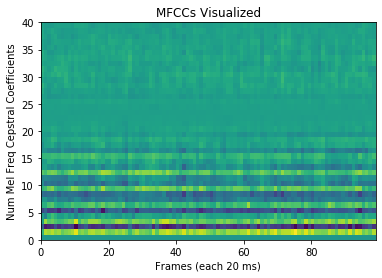

In [10]:
visualize_feats(street, features = 'mfcc',num_mfcc=40, win_size_ms=20, win_shift_ms=10)

#### FBANK

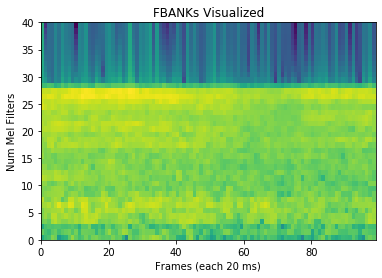

In [11]:
visualize_feats(street, features = 'fbank',num_filters=40, win_size_ms=20, win_shift_ms=10)

### Speech Commands:

Loaded files you can try out: 
* nine
* right
* zero

#### MFCC

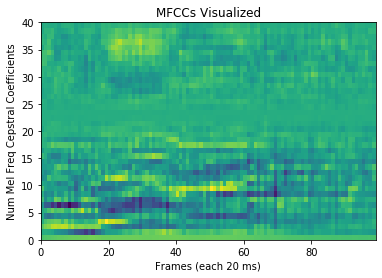

In [12]:
visualize_feats(zero, features = 'mfcc',num_mfcc=40, win_size_ms=20, win_shift_ms=10)

#### FBANK

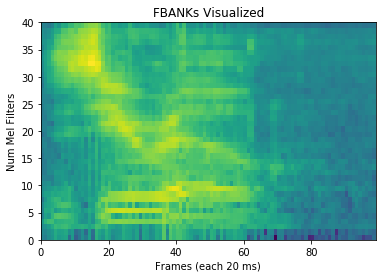

In [13]:
visualize_feats(zero, features = 'fbank',num_filters=40, win_size_ms=20, win_shift_ms=10)

## Build a Sound Classifier!

In [14]:
from pysoundtool.templates import soundclassifier

### Set directory for saving newly created files

In [15]:
path2_features_models = './saved_features_and_models/'

#### Name Project 

Tip: include something about the data used to train the classifier

In [16]:
project_backgroundnoise = 'background_noise'

Running the following code will extract 'mfcc' features from the audio data provided. These features will then be used to train a convolutional neural network to classify such data as either sound most similar to 'buzzing', 'street', or 'train' noise.

In [17]:
soundclassifier(classifier_project_name = project_backgroundnoise, 
                headpath = path2_features_models,
                audiodir = path2_backgroundnoise_data,
                feature_type = 'mfcc')

multiple models found. chose this model:
saved_features_and_models/background_noise/models/mfcc_40_1.0/background_noise_model/bestmodel_background_noise_model.h5

Features have been extracted.

Loading corresponding feature settings.


Using TensorFlow backend.



Loading previously trained classifier.


### Use the classifier to classify new data!

In [18]:
rain_noise = '../audiodata/rain.wav'
sr, samps = read(rain_noise)
ipd.Audio(samps,rate=sr)

In [19]:
soundclassifier(classifier_project_name = project_backgroundnoise, 
                headpath = path2_features_models,
                audiodir=path2_backgroundnoise_data,
                target_wavfile = rain_noise, # the sound we want to classify
                feature_type='mfcc')

multiple models found. chose this model:
saved_features_and_models/background_noise/models/mfcc_40_1.0/background_noise_model/bestmodel_background_noise_model.h5

Features have been extracted.

Loading corresponding feature settings.

Loading previously trained classifier.

Label classified:  cafe


#### The classifier labeled the rain noise as belonging to the class 'cafe'. 

## Challenges

1) 

Try training the background noise classifier with the `feature_type` 'fbank' instead of 'mfcc'. Do you notice a difference? Does the rain noise still get labeled as 'cafe' noise?

2) 

Collect a sound or two you would like to classify with this classifier, for example from <a href='https://freesound.org/search/?g=1&q=background%20noise&f=%20type:%22wav%22%20bitdepth:%2216%22%20channels:%221%22'>freesound.org</a>. You will need to create a free account in order to download sounds, which I highly encourage. Note: as of now, this tool can only process 16 or 32-bit wavfiles. The link offered should be set to only show sounds that adhere to those requirements.

3) 

Build a speech commands classifier using the data provided in the `speech_commands_sample` folder. Try adjusting the arguments for `noizeclassifier`, such as features extraced ('mfcc' vs 'fbank').

How do you think the classifier will classify the following words: 'left', 'marvin', and 'wow'? 
* marvin

In [20]:
marvin = '../audiodata/marvin.wav'
sr, samps = read(marvin)
ipd.Audio(samps,rate=sr)

* left

In [21]:
left = '../audiodata/left.wav'
sr, samps = read(left)
ipd.Audio(samps,rate=sr)

* wow

In [22]:
wow = '../audiodata/wow.wav'
sr, samps = read(wow)
ipd.Audio(samps,rate=sr)

And how does the classifer actually classify them? Are the classifications the same for both 'mfcc' and 'fbank' features? Which adhere better to your expectations?

4) 

Advanced: 

Adjust the model architecture in the file 'cnn.py'. This can be located in the following directory: './noize/models/'. You can try implementing another convolutional neural network (CNN) architecture or even try adding a long short-term memory network (LSTM). This latter option would require a bit of fiddling around with data input sizes.

### A little prompt to get you started


In [23]:
project_speechcommands = 'speech_commands'

In [24]:
soundclassifier(classifier_project_name = project_speechcommands, 
                headpath = path2_features_models,
                audiodir=path2_speechcommands_data,
                target_wavfile = marvin, # file for classification - test out the other words as well
                feature_type='mfcc' # try 'fbank' features and see if the validation score increases or decreases
               ) 

multiple models found. chose this model:
saved_features_and_models/speech_commands/models/mfcc_40_1.0/speech_commands_model/bestmodel_speech_commands_model.h5

Features have been extracted.

Loading corresponding feature settings.

Loading previously trained classifier.

Label classified:  nine


In [25]:
soundclassifier(classifier_project_name = project_speechcommands, 
                headpath = path2_features_models,
                audiodir=path2_speechcommands_data,
                target_wavfile = marvin, 
                feature_type='fbank' 
               ) 

multiple models found. chose this model:
saved_features_and_models/speech_commands/models/fbank_40_1.0/speech_commands_model/bestmodel_speech_commands_model.h5

Features have been extracted.

Loading corresponding feature settings.

Loading previously trained classifier.

Label classified:  nine


In [26]:
soundclassifier(classifier_project_name = project_speechcommands, 
                headpath = path2_features_models,
                audiodir=path2_speechcommands_data,
                target_wavfile = wow, 
                feature_type='mfcc' 
               ) 

multiple models found. chose this model:
saved_features_and_models/speech_commands/models/mfcc_40_1.0/speech_commands_model/bestmodel_speech_commands_model.h5

Features have been extracted.

Loading corresponding feature settings.

Loading previously trained classifier.

Label classified:  zero


In [27]:
soundclassifier(classifier_project_name = project_speechcommands, 
                headpath = path2_features_models,
                audiodir=path2_speechcommands_data,
                target_wavfile = wow, 
                feature_type='fbank' 
               ) 

multiple models found. chose this model:
saved_features_and_models/speech_commands/models/fbank_40_1.0/speech_commands_model/bestmodel_speech_commands_model.h5

Features have been extracted.

Loading corresponding feature settings.

Loading previously trained classifier.

Label classified:  right
